In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import os, sys
%matplotlib inline

os.chdir('..\..\..\..')

# from input_configuration import base_year
import toml
config = toml.load(os.path.join(os.getcwd(), 'configuration/input_configuration.toml'))

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
working_dir = r'outputs/agg/dash'
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

In [3]:
def load_data(fname):
    """ open and join model and survey data """

    df_model = pd.read_csv(os.path.join(working_dir,fname+'.csv'))
    df_model['source'] = 'model'
    df_survey = pd.read_csv(os.path.join(working_dir,'survey',fname+'.csv'))
    df_survey['source'] = 'survey'
    df = df_model.append(df_survey)

    return df

In [4]:
parcel_geog = pd.read_sql_table('parcel_'+config['base_year']+'_geography', 'sqlite:///inputs/db/soundcast_inputs.db',
        columns=['CountyName','ParcelID'])

# Usual Work Distance

In [5]:
person = pd.read_csv(r'outputs/daysim/_person.tsv', delim_whitespace=True)
person_survey = pd.read_csv(r'inputs/base_year/survey/_person.tsv', delim_whitespace=True)

person['source'] = 'model'
person_survey['source'] = 'survey'

In [6]:
person = person.append(person_survey)
person = person.merge(parcel_geog, left_on='pwpcl', right_on='ParcelID', how='left')

In [7]:
person['wt_pwautime'] = person['pwautime']*person['psexpfac']
person['wt_pwaudist'] = person['pwaudist']*person['psexpfac']

Average Distance for **All Workers** Not Working at Home (weighted for survey)

In [8]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    11.87
survey   11.71
dtype: float64

Average Distance by Work County

In [9]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,12.63,12.61
Kitsap,9.80,8.68
Pierce,10.25,10.09
Snohomish,10.64,10.02


Average for **Full-Time** Workers only

In [10]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0) & (person['pwtyp'] == 1)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    12.61
survey   12.43
dtype: float64

In [11]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,13.31,13.19
Kitsap,10.73,9.12
Pierce,10.98,11.55
Snohomish,11.37,10.51


Average for **Part-Time** Workers Only

In [12]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0) & (person['pwtyp'] == 1)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    12.61
survey   12.43
dtype: float64

In [13]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,13.31,13.19
Kitsap,10.73,9.12
Pierce,10.98,11.55
Snohomish,11.37,10.51


## Trip Length Distribution (miles)
Percent of Total, bins of 1 mile up to 60 miles

All Workers

<AxesSubplot:xlabel='pwaudist_bin'>

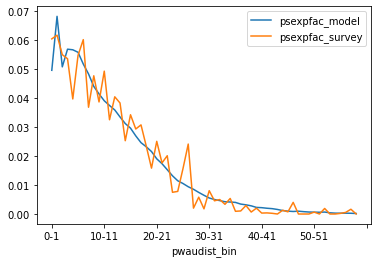

In [14]:
# Create bins
max_bin = 60
person['pwaudist_bin'] = pd.cut(person['pwaudist'], bins=range(0,max_bin), labels=[str(i)+'-'+str(i+1) for i in range(0,max_bin-1)])
df1 = person[(person['source'] == 'model') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df1 = df1.groupby('pwaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('pwaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot()

Bins of 5 miles, up to 50 miles

<AxesSubplot:xlabel='pwaudist_bin'>

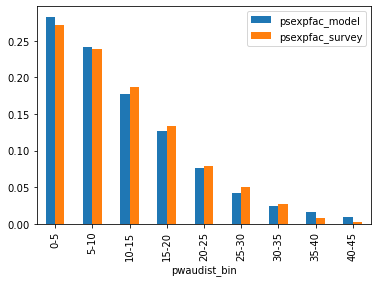

In [15]:
# Create bins
max_bin = 50
person['pwaudist_bin'] = pd.cut(person['pwaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,9)])
df1 = person[(person['source'] == 'model') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df1 = df1.groupby('pwaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('pwaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot(kind='bar')

### Percent of Workers with <1 Mile and >20 Mile Commutes

In [16]:
pd.options.display.float_format = '{:,.1%}'.format

_df_tot = person[person['pwaudist'] > 0].groupby('source').sum()[['psexpfac']].T

_df_1 = person[(person['pwaudist'] < 1) & (person['pwaudist'] > 0)].groupby('source').sum()[['psexpfac']].T
_df_1 = _df_1/_df_tot
_df_1.index = ['< 1 mile']

_df_20 = person[(person['pwaudist'] > 20)].groupby('source').sum()[['psexpfac']].T
_df_20 = _df_20/_df_tot
_df_20.index = ['> 20 miles']

_df = _df_1.append(_df_20).reset_index()
_df.rename(columns={'index': 'Commute Range'}, inplace=True)
_df = _df.rename_axis(None, axis=1)
_df

,Commute Range,model,survey
0,< 1 mile,4.9%,6.0%
1,> 20 miles,17.5%,17.3%


<AxesSubplot:xlabel='Commute Range'>

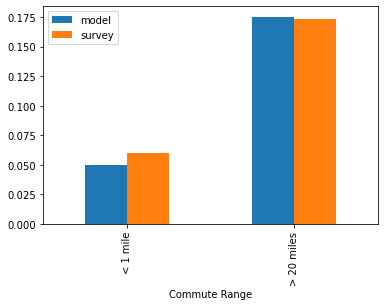

In [17]:
_df.set_index('Commute Range').plot(kind='bar',)

### Average Commute Distance by Gender

In [18]:
pd.options.display.float_format = '{:0,.2f}'.format
df = person[(person['pwaudist'] > 0) & (person['pgend'].isin([1,2]))]
_df = df.pivot_table(index='pgend', columns='source', aggfunc='sum', values='wt_pwaudist')
_df_tot = df.pivot_table(index='pgend', columns='source', aggfunc='sum', values='psexpfac')
df = _df/_df_tot
df = df.reset_index()
df['pgend'] = df['pgend'].map({1: 'Male',2:'Female'})
df.rename(columns={'pgend': 'Gender'}, inplace=True)
df = df.rename_axis(None, axis=1)
df

,Gender,model,survey
0,Male,12.80,12.60
1,Female,10.70,10.47


<AxesSubplot:xlabel='Gender'>

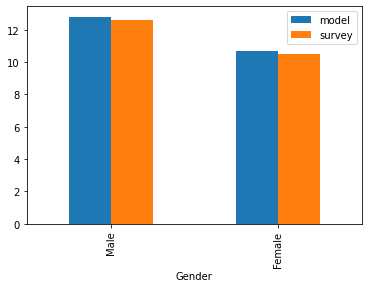

In [19]:
df.set_index('Gender').plot(kind='bar')

### Average Commute Distance by Age

In [20]:
person['age_cat'] = pd.cut(person['pagey'], bins=[0,30,50,64,100], labels=['<29','30-49','50-65','65+'])
df = person[(person['pwaudist'] > 0)]
_df = df.pivot_table(index='age_cat', columns='source', aggfunc='sum', values='wt_pwaudist')
_df_tot = df.pivot_table(index='age_cat', columns='source', aggfunc='sum', values='psexpfac')
df = _df/_df_tot
df = df.reset_index()
df.rename(columns={'age_cat': 'Age Category'}, inplace=True)
df = df.rename_axis(None, axis=1)
df

,Age Category,model,survey
0,<29,10.57,10.25
1,30-49,12.10,12.63
2,50-65,12.70,12.23
3,65+,11.60,9.61


<AxesSubplot:xlabel='Age Category'>

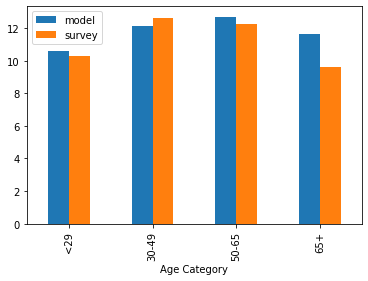

In [21]:
df.set_index('Age Category').plot(kind='bar')

## County to County Work Flows

All Workers

Model Results 

In [22]:
df = load_data(r'work_flows')
pd.options.display.float_format = '{:0,.0f}'.format
df.rename(columns={'person_county': 'Home County', 'person_work_county':'Work County'}, inplace=True)

df_model = pd.pivot_table(df[df['source'] == 'model'], index='Home County', columns='Work County', aggfunc='sum')
df_model['Total'] = df_model.sum(axis=1)
df_model.loc['Total',:] = df_model.sum(axis=0)
df_model

psexpfac                              Total
Work County      King Kitsap  Pierce Snohomish          
Home County                                             
King        1,011,311    330  35,228    43,440 1,090,309
Kitsap         12,995 88,138   8,240       239   109,612
Pierce        109,761  6,966 228,649       608   345,984
Snohomish     143,610     38     474   229,237   373,359
Total       1,277,677 95,472 272,591   273,524 1,919,264

Survey Results

In [23]:
df_survey = pd.pivot_table(df[df['source'] == 'survey'], index='Home County', columns='Work County', aggfunc='sum')
df_survey['Total'] = df_survey.sum(axis=1)
df_survey.loc['Total',:] = df_survey.sum(axis=0)
df_survey

psexpfac                              Total
Work County      King Kitsap  Pierce Snohomish          
Home County                                             
King          872,877    526  23,130    14,610   911,144
Kitsap         20,710 62,212   8,580       NaN    91,503
Pierce         65,276 10,745 220,524       NaN   296,546
Snohomish     122,381    NaN     NaN   197,237   319,618
Total       1,081,245 73,484 252,235   211,847 1,618,810

Total Difference (Model - Survey)

In [24]:
df_model-df_survey

psexpfac                           Total
Work County     King Kitsap Pierce Snohomish        
Home County                                         
King         138,434   -196 12,098    28,830 179,165
Kitsap        -7,715 25,926   -340       NaN  18,109
Pierce        44,485 -3,779  8,125       NaN  49,438
Snohomish     21,229    NaN    NaN    32,000  53,741
Total        196,432 21,988 20,356    61,677 300,454

Percent Difference (Relative to Survey)

In [25]:
((df_model-df_survey)/df_survey).applymap(format_percent)

psexpfac                              Total
Work County     King   Kitsap  Pierce Snohomish        
Home County                                            
King          15.86%  -37.26%  52.30%   197.33%  19.66%
Kitsap       -37.25%   41.67%  -3.97%      nan%  19.79%
Pierce        68.15%  -35.17%   3.68%      nan%  16.67%
Snohomish     17.35%     nan%    nan%    16.22%  16.81%
Total         18.17%   29.92%   8.07%    29.11%  18.56%